<a href="https://colab.research.google.com/github/ehtisham409/extractive-summarization-using-deep-learning/blob/main/extractive_summarization_using_deepleanring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your dataset
data = pd.read_csv('/content/mathematical_data.csv')

# Split data into training, validation, and test sets
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Extract article and summary columns
train_articles = train_data['article'].tolist()
train_summaries = train_data['summary'].tolist()

val_articles = val_data['article'].tolist()
val_summaries = val_data['summary'].tolist()

test_articles = test_data['article'].tolist()
test_summaries = test_data['summary'].tolist()


In [4]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.1 MB/s eta 0:00:00


In [5]:
from transformers import BartForConditionalGeneration
import torch
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerN

In [6]:
from transformers import BartTokenizer

tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

In [7]:
max_length = 128       # Set an appropriate maximum sequence length
train_tokenized = tokenizer(train_articles, train_summaries, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
val_tokenized = tokenizer(val_articles, val_summaries, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
test_tokenized = tokenizer(test_articles, test_summaries, padding=True, truncation=True, max_length=max_length, return_tensors='pt')

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [8]:
from torch.utils.data import DataLoader, Dataset
class SummarizationDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]  # For language modeling
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SummarizationDataset(train_tokenized, train_tokenized['input_ids'])
val_dataset = SummarizationDataset(val_tokenized, val_tokenized['input_ids'])
test_dataset = SummarizationDataset(test_tokenized, test_tokenized['input_ids'])
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
from transformers import BartForConditionalGeneration, BartTokenizer, AdamW

model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Loss: 2.0927
Epoch 2/10, Loss: 1.5544
Epoch 3/10, Loss: 1.0688
Epoch 4/10, Loss: 0.6543
Epoch 5/10, Loss: 0.4098
Epoch 6/10, Loss: 0.2873
Epoch 7/10, Loss: 0.2107
Epoch 8/10, Loss: 0.1695
Epoch 9/10, Loss: 0.1387
Epoch 10/10, Loss: 0.1179


In [10]:
# Set the model to evaluation mode
model.eval()

# Function to generate summaries
def generate_summary(article_text):
    inputs = tokenizer.encode("summarize: " + article_text, return_tensors="pt", max_length=1024, truncation=True)
    inputs = inputs.to(device)
    summary_ids = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Example usage
article_text = "Linear algebra is a fundamental branch of mathematics that deals with vector spaces and linear mappings between these spaces. Vectors, represented as arrays of numbers, are used to store and manipulate data. Matrices, which are 2-dimensional arrays, provide a convenient way to perform operations on multiple vectors simultaneously. Vectors and matrices form the foundation for various machine learning algorithms, enabling efficient data processing and transformation."
generated_summary = generate_summary(article_text)
print("Generated Summary:", generated_summary)


Generated Summary:  Linear algebra is a fundamental branch of mathematics that deals with vector spaces and linear mappings between these spaces. Vectors, represented as arrays of numbers, are used to store and manipulate data. Matrices, which are 2-dimensional arrays, provide a convenient way to perform operations on multiple vectors simultaneously.


In [11]:
!pip install rouge

In [12]:
from rouge import Rouge

# Function to calculate ROUGE scores
def calculate_rouge_scores(generated_summaries, reference_summaries):
    rouge = Rouge()
    scores = rouge.get_scores(generated_summaries, reference_summaries, avg=True)
    return scores

# Example usage for evaluation
test_reference_summaries = test_data['summary'].tolist()  # Use reference summaries from the test dataset

# Generate summaries for the test set
generated_summaries = []
for article_text in test_articles:
    summary = generate_summary(article_text)
    generated_summaries.append(summary)

# Calculate ROUGE scores
rouge_scores = calculate_rouge_scores(generated_summaries, test_reference_summaries)
print("ROUGE Scores:", rouge_scores)


ROUGE Scores: {'rouge-1': {'r': 0.500408767477733, 'p': 0.3351599406444584, 'f': 0.4006892804370153}, 'rouge-2': {'r': 0.22725503366221542, 'p': 0.14147090897211292, 'f': 0.17401040919521335}, 'rouge-l': {'r': 0.4901273821963477, 'p': 0.3277903261319867, 'f': 0.3921178518655868}}


Epoch 1/10, Training Loss: 0.0390, Validation Loss: 0.0413
Epoch 2/10, Training Loss: 0.0336, Validation Loss: 0.0285
Epoch 3/10, Training Loss: 0.0296, Validation Loss: 0.0431
Epoch 4/10, Training Loss: 0.0273, Validation Loss: 0.0397
Epoch 5/10, Training Loss: 0.0241, Validation Loss: 0.0257
Epoch 6/10, Training Loss: 0.0218, Validation Loss: 0.0274
Epoch 7/10, Training Loss: 0.0202, Validation Loss: 0.0291
Epoch 8/10, Training Loss: 0.0189, Validation Loss: 0.0282
Epoch 9/10, Training Loss: 0.0170, Validation Loss: 0.0204
Epoch 10/10, Training Loss: 0.0159, Validation Loss: 0.0396


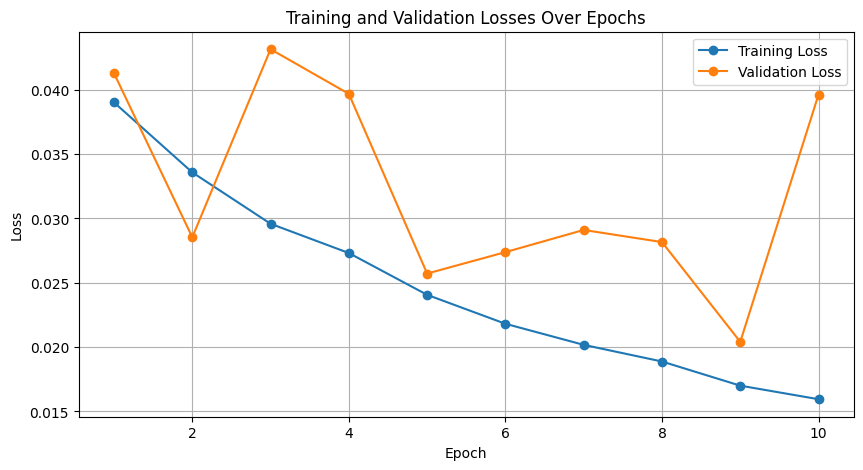

In [16]:
import torch
from transformers import BartForConditionalGeneration, BartTokenizer, AdamW
import matplotlib.pyplot as plt

# Your existing code for model, tokenizer, and data loaders

optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 10

# Lists to store training and validation losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    # Your training loop here
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    # Calculate average training loss
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # After training, calculate the validation loss
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        # Your validation loop here, similar to the training loop but without optimizer steps
        for val_batch in val_loader:
            # Compute validation loss
            val_input_ids = val_batch['input_ids'].to(device)
            val_attention_mask = val_batch['attention_mask'].to(device)
            val_labels = val_batch['labels'].to(device)

            val_outputs = model(val_input_ids, attention_mask=val_attention_mask, labels=val_labels)
            val_loss = val_outputs.loss
            total_val_loss += val_loss.item()

    # Calculate average validation loss
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Plotting training and validation losses
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
